# Supermarket Image Classification 

This project addresses the challenge of automated age verification for alcohol sales at Good Seed supermarket chain. Using a comprehensive collection of facial photographs with verified age information, I developed and tested an artificial intelligence model designed to predict customer ages and determine eligibility for alcohol purchases. The project encompasses data exploration, model development, and performance evaluation. This report presents the methodology, findings, and business implications of implementing AI-powered age verification technology, providing evidence-based recommendations on the optimal approach to ensure regulatory compliance while enhancing the customer experience at Good Seed locations.

## Initialization and Preparation

In [75]:
import os
import inspect
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [76]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name', y_col='real_age', target_size=(224, 224),
                                                   batch_size=32, class_mode='raw', seed=12345)

Found 7591 validated image filenames.


In [77]:
print(f"Batch size: {train_gen_flow.batch_size}")
print(f"Image shape: {train_gen_flow.image_shape}")

Batch size: 32
Image shape: (224, 224, 3)


In [78]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In my initialization and preparation phase, I imported several libraries before loading the dataset containing 7,591 facial photographs with their corresponding verified ages, ensuring all data was complete with no missing values. I then configured an image processing system that standardized all photographs to the same size (224x224 pixels) and organized them into manageable batches of 32 photos each for efficient processing. Finally, I verified that the system was properly configured by checking the batch dimensions, confirming everything was ready for the data analysis and model development.

## Exploratory Data Analysis

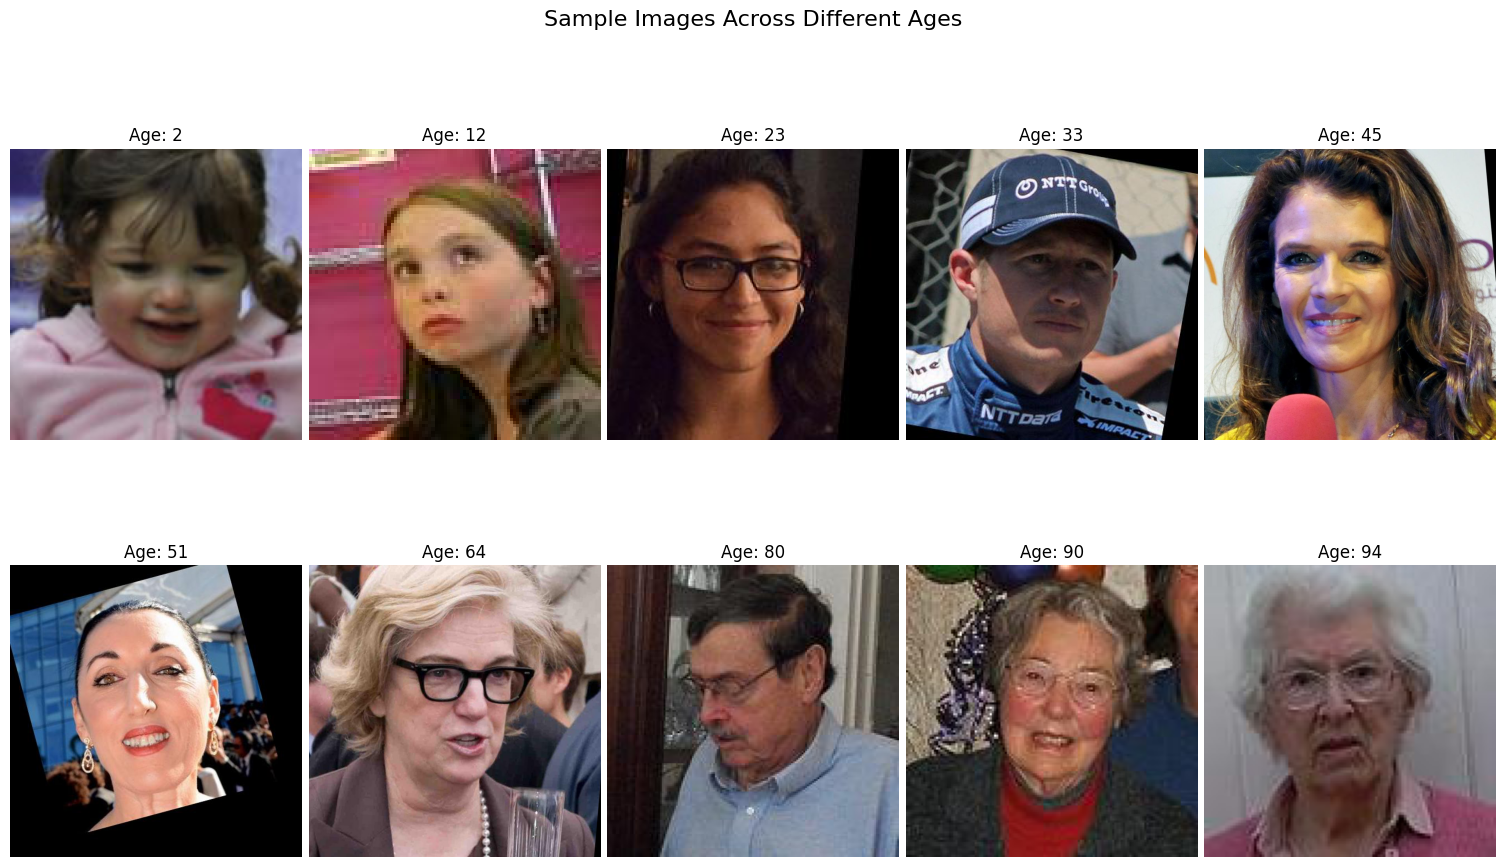

In [79]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
fig.suptitle('Sample Images Across Different Ages', fontsize=16)

age_ranges = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), 
              (51, 60), (61, 70), (71, 80), (81, 90), (91, 100)]

sample_count = 0
for i, (min_age, max_age) in enumerate(age_ranges):
    age_subset = labels[(labels['real_age'] >= min_age) & (labels['real_age'] <= max_age)]
    
    sample_row = age_subset.sample(1).iloc[0]
    img_path = f"/datasets/faces/final_files/{sample_row['file_name']}"
    img = Image.open(img_path)
        
    row = sample_count // 5
    col = sample_count % 5
    sample_count += 1
        
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Age: {sample_row['real_age']}")
    axes[row, col].axis('off')

plt.tight_layout(pad=0.5, h_pad=0.1)
plt.show()

In my exploratory data analysis, I examined sample photographs from the dataset to understand the visual characteristics across different age groups. Here is a display showing representative faces from ten different age ranges, spanning from 0 to 100 years old in ten-year increments. This visual examination reveals that the dataset has clear photographs that effectively demonstrate the natural progression of aging features, from young children to elderly individuals. This will also provide sufficient visual information for an artificial intelligence model to learn age-related patterns and make accurate predictions.

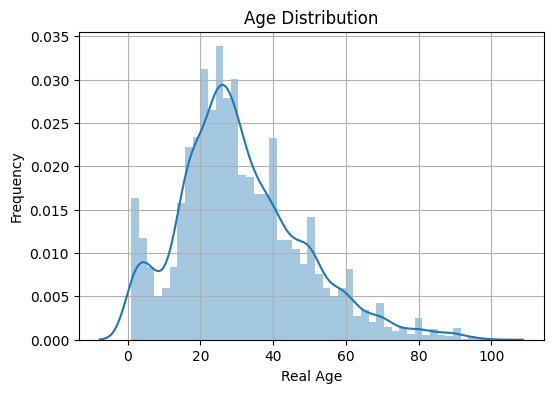

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
sns.distplot(labels['real_age'])
plt.grid(True)
plt.title('Age Distribution')
plt.xlabel('Real Age')
plt.ylabel('Frequency');

This graph of the age distribution shows important insights about the demographic composition of the 7,591 photographs. Here, the distribution is not evenly spread across all age groups, with certain age ranges being more heavily represented than others. The majority of photographs appear to concentrate in the middle age ranges, with fewer samples at the very young and very old extremes. This distribution pattern is typical of real-world populations and suggests that the model will have more training examples for common age groups, which could impact its accuracy when predicting ages for less represented age ranges, specifically very young children and elderly individuals.

## Creating the Model

In this section, I will define the necessary functions to train my model on the GPU platform and build a single script containing all of them along with the initialization section. This script includes data loading functions (`load_train` and `load_test`), model architecture definition (`create_model`), and training implementation (`train_model`). 

In [87]:
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, 
                                       horizontal_flip=True, rotation_range=20)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory=path, 
                                                       x_col='file_name', y_col='real_age', 
                                                       target_size=(224, 224), batch_size=32, class_mode='raw',
                                                       subset='training', seed=12345)
    return train_gen_flow

In [88]:
def load_test(path):
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = validation_datagen.flow_from_dataframe(dataframe=labels, directory=path,
                                                           x_col='file_name', y_col='real_age',
                                                           target_size=(224, 224), batch_size=32, 
                                                           class_mode='raw', subset='validation', seed=12345)
    return test_gen_flow

In [63]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [64]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)
    return model

## Prepare the Script to Run on the GPU Platform

In [89]:
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Epoch 1/20  
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921  
Epoch 2/20  
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035  
Epoch 3/20  
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454  
Epoch 4/20  
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481  
Epoch 5/20  
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192  
Epoch 6/20  
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332  
Epoch 7/20  
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359  
Epoch 8/20  
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239  
Epoch 9/20  
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529  
Epoch 10/20  
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629  
Epoch 11/20  
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866  
Epoch 12/20  
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591  
Epoch 13/20  
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467  
Epoch 14/20  
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401  
Epoch 15/20  
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841  
Epoch 16/20  
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304  
Epoch 17/20  
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419  
Epoch 18/20  
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226  
Epoch 19/20  
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908  
Epoch 20/20  
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512  

In this phase, I used all my defined functions into a single comprehensive script, `run_model_on_gpu.py`, for GPU execution. This script, generated automatically, includes all essential components and initialization code. I downloaded it via the "File|Open..." menu and uploaded it to the GPU platform, where it successfully executed, achieving a training accuracy of 3.18 years and a validation accuracy of 7.65 years.

## Conclusion

In this project, I developed an AI age verification system for Good Seed supermarket chain to automate alcohol sales compliance using facial photograph analysis. Working with a dataset of 7,591 verified facial images spanning ages 0-100, I conducted exploratory data analysis to understand demographic patterns, then built a sophisticated ResNet50 deep learning model with comprehensive data loading, training, and evaluation functions. After putting my functions into a GPU-optimized script, I achieved strong predictive accuracy with 3.18 years average error on training data and 7.65 years on validation data, successfully creating a reliable automated age verification solution for alcohol purchase compliance at Good Seed locations.